In [1]:
from unyt import Msun, erg, kg, eV, Angstrom, c, s, cm, h
from synthesizer.grid import Grid
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import cmasher as cmr
import copy

# set style
plt.style.use('../matplotlibrc.txt')


Kennicutt (1998) value (here for validation)

In [2]:
# for converting Q to Halpha luminosity from Kennicutt 1998
Kennicutt98 = (1.08E-53 / 7.9E-42) * erg
print(Kennicutt98)


1.3670886075949369e-12 erg


# Derivation of calibrations

In [3]:

alpha = {}
alpha['B'] = {}
alpha['B'][5000] = 4.54E-13 * cm**3 / s
alpha['B'][10000] = 2.59E-13 * cm**3 / s
alpha['B'][14000] = 2.0E-13 * cm**3 / s #GUESS
alpha['B'][20000] = 1.43E-13 * cm**3 / s

alpha_Hbeta = {}
alpha_Hbeta['A'] = {}
alpha_Hbeta['A'][5000] = 3.78E-14 * cm**3 / s
alpha_Hbeta['A'][10000] = 2.04E-14 * cm**3 / s
alpha_Hbeta['A'][20000] = 1.03E-14 * cm**3 / s

alpha_Hbeta['B'] = {}
alpha_Hbeta['B'][5000] = 5.37E-14 * cm**3 / s
alpha_Hbeta['B'][10000] = 3.03E-14 * cm**3 / s
alpha_Hbeta['B'][14000] = 2.3E-14 * cm**3 / s # GUESS
alpha_Hbeta['B'][20000] = 1.62E-14 * cm**3 / s


# relative to Hbeta
relative_line_intensities = {}
relative_line_intensities['A'] = {}
relative_line_intensities['A']['Halpha'] = {}
relative_line_intensities['A']['Halpha'][5000] = 3.10
relative_line_intensities['A']['Halpha'][10000] = 2.86
relative_line_intensities['A']['Halpha'][20000] = 2.69

relative_line_intensities['B'] = {}
relative_line_intensities['B']['Halpha'] = {}
relative_line_intensities['B']['Halpha'][5000] = 3.05
relative_line_intensities['B']['Halpha'][10000] = 2.87
relative_line_intensities['B']['Halpha'][20000] = 2.76

energy = {}
energy['Halpha'] = 1.89 * eV
energy['Hbeta'] = 2.55 * eV



## Low-density limit

### Number of photons per recombination

$\alpha_{H\beta}/\alpha_{B}$

In [4]:
line = 'Hbeta'
temperature = 10000
print(alpha_Hbeta['B'][temperature]/alpha['B'][temperature])

0.11698841698841698 dimensionless


### Luminosity per ionising photon

$L_{H\beta} / \int_{\nu_0}^{\infty}\frac{L_{\nu}{h\nu}}{\rm d}\nu = h\nu_{H\beta}\frac{\alpha_{H\beta}}{\alpha_{B}}$

In [5]:
# Hbeta
conversion_Hbeta = energy['Hbeta']*alpha_Hbeta['B'][temperature]/alpha['B'][temperature]
print(conversion_Hbeta.to('erg'))

4.77962054297027e-13 erg


In [6]:
conversion_Halpha_low_density = conversion_Hbeta * relative_line_intensities['B']['Halpha'][temperature]
print(conversion_Halpha_low_density.to('erg'))

1.3717510958324675e-12 erg


## BLR

Taken from Page 366 of Osterbrok

In [7]:
homogeneous_blr_relative_line_intensities = {}
homogeneous_blr_relative_line_intensities[10000] = {}
homogeneous_blr_relative_line_intensities[10000]['B'] = 0.77 # the case B value
homogeneous_blr_relative_line_intensities[10000]['Halpha'] = 4.94

homogeneous_blr_relative_line_intensities[14000] = {}
homogeneous_blr_relative_line_intensities[14000]['B'] = 4.52 # the case B value
homogeneous_blr_relative_line_intensities[14000]['Halpha'] = 5.70

In [8]:


def calculate_conversion(temperature):

    conversion_Hbeta_blr = energy['Hbeta'] * (alpha_Hbeta['B'][temperature]/alpha['B'][temperature]) / homogeneous_blr_relative_line_intensities[temperature]['B']

    conversion_Halpha_blr = conversion_Hbeta_blr * homogeneous_blr_relative_line_intensities[temperature]['Halpha']

    return conversion_Halpha_blr


for temperature in [10000, 14000]:

    conversion_Halpha_blr = calculate_conversion(temperature)    

    print(f"{temperature} {conversion_Halpha_blr.to('erg')}, {conversion_Halpha_blr/conversion_Halpha_low_density}")


conversion_Halpha_blr = calculate_conversion(10000)    
print(conversion_Halpha_blr.to('erg'))

10000 3.0664059067887187e-12 erg, 2.235395266754152 dimensionless
14000 5.924951720789934e-13 erg, 0.4319261518208804 dimensionless
3.0664059067887187e-12 erg


# Create grid plots

In [9]:
disc_model = 'qsosed-isotropic'
grid_name = disc_model

# photoionisation_model = 'cloudy-c23.01'
# base_grid_name = f'{disc_model}_{photoionisation_model}'
# grid_name = base_grid_name+'-'+grid_type

grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid_type = 'nlr'

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

masses = grid.mass * Msun


In [10]:
def convert_to_bin_edges(arr):
    """ converts an array to bin edges assuming it is regular """

    delta = arr[1] - arr[0]
    edges = arr - delta/2.
    edges = np.append(edges, edges[-1] + delta)

    return edges

## Ionising photon bolometric correction

9.222270806091004 10.13604144539758


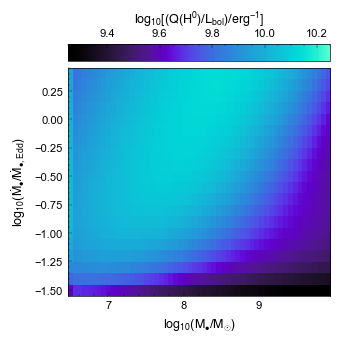

8.594615750415347 9.545052284638707


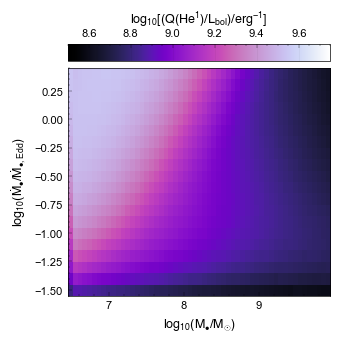

In [16]:
for ion in ['HI', 'HeII']:

    if ion == 'HI': 
        ion_label = 'H^0'
        vmin, vmax = 9.25, 10.25
        cmap = cmr.cosmic
    if ion == 'HeII': 
        ion_label = 'He^1'
        vmin, vmax = 8.5, 9.75
        cmap = cmr.gothic

    g = grid.log10_specific_ionising_lum[ion]

    print(np.min(g), np.max(g))

    x_bin_edges = convert_to_bin_edges(np.log10(masses.to('Msun').value)) 
    y_bin_edges = convert_to_bin_edges(np.log10(grid.accretion_rate_eddington))

    left = 0.2
    right = 0.95
    bottom = 0.15
    top = 0.8

    fig, ax = plt.subplots(figsize=(3.5,3.5))
    plt.subplots_adjust(
        left=left, 
        right=right, 
        top=top, 
        bottom=bottom)

    cax = fig.add_axes((left, top+0.02, right-left, 0.05))

   
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # norm = mpl.colors.Normalize()

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation = 'horizontal') # add the colourbar

    cax.xaxis.tick_top()
    cax.xaxis.set_label_position('top')
    cax.set_xlabel(rf'$\rm log_{{10}}[(Q({ion_label})/L_{{\rm bol}})/erg^{{-1}}]$')


    extent = (x_bin_edges[0], x_bin_edges[-1], y_bin_edges[0], y_bin_edges[-1])

    ax.imshow(g.T, aspect = 'auto', origin = 'lower', cmap = cmap, extent = extent, vmin=vmin, vmax=vmax)
    # ax.imshow(slice, aspect = 'auto', origin = 'lower', extent = (z_bin_edges[0], z_bin_edges[-1], log10L_bin_edges[0], log10L_bin_edges[-1]), vmin = vmin, vmax = vmax, cmap = cmap)

    ax.set_xlabel(r'$\rm log_{10}(M_{\bullet}/M_{\odot})$')
    ax.set_ylabel(r'$\rm log_{10}(\dot{M}_{\bullet}/\dot{M}_{\bullet, Edd})$')

    ax.grid(False)

    fig.savefig(f'figures/qsosed_{ion}_ionising_bolometric_correction.pdf')
    plt.show()

## Halpha bolometric correction

In [12]:
# ionising photon bolometric correction
ionising_bolometric_conversion = 10**grid.log10_specific_ionising_lum['HI'] / s

Halpha_bolometric_correction = ionising_bolometric_conversion * conversion_Halpha_blr

print(np.max(1/Halpha_bolometric_correction.to('erg/s').value))

spectra = grid.get_sed(spectra_type='incident')

195.478749027916


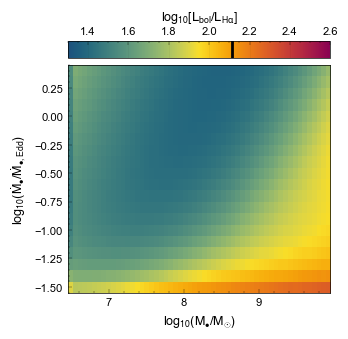

In [13]:
vmin, vmax = 1.3, 2.6
cmap = cmr.get_sub_cmap(cmr.pride, 0.15, 0.85)


x_bin_edges = convert_to_bin_edges(np.log10(masses.to('Msun').value)) 
y_bin_edges = convert_to_bin_edges(np.log10(grid.accretion_rate_eddington))

left = 0.2
right = 0.95
bottom = 0.15
top = 0.8

fig, ax = plt.subplots(figsize=(3.5,3.5))
plt.subplots_adjust(
    left=left, 
    right=right, 
    top=top, 
    bottom=bottom)

cax = fig.add_axes((left, top+0.02, right-left, 0.05))
cax.axvline(np.log10(130.), c='k', lw=2)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.Normalize()

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation = 'horizontal') # add the colourbar

cax.xaxis.tick_top()
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\rm log_{{10}}[L_{bol}/L_{H\alpha}]$')


extent = (x_bin_edges[0], x_bin_edges[-1], y_bin_edges[0], y_bin_edges[-1])


ax.imshow(np.log10(1/Halpha_bolometric_correction.to('erg/s').value.T), aspect = 'auto', origin = 'lower', cmap = cmap, extent = extent, vmin=vmin, vmax=vmax)
# ax.imshow(slice, aspect = 'auto', origin = 'lower', extent = (z_bin_edges[0], z_bin_edges[-1], log10L_bin_edges[0], log10L_bin_edges[-1]), vmin = vmin, vmax = vmax, cmap = cmap)

ax.set_xlabel(r'$\rm log_{10}(M_{\bullet}/M_{\odot})$')
ax.set_ylabel(r'$\rm log_{10}(\dot{M}_{\bullet}/\dot{M}_{\bullet, Edd})$')

ax.grid(False)

fig.savefig(f'figures/qsosed_halpha_bolometric_correction.pdf')
plt.show()

### Get EW

In [14]:
lnu = spectra.measure_window_lnu((6550, 6590) * Angstrom)
llam = lnu * c / (6575 * Angstrom)**2
ew = Halpha_bolometric_correction / llam

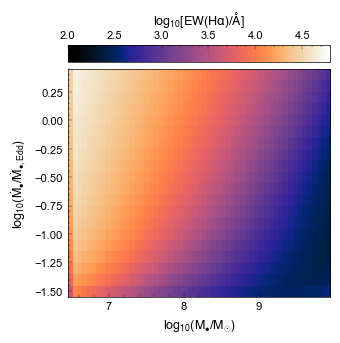

In [15]:
vmin, vmax = 2., 4.8
cmap = cmr.torch


x_bin_edges = convert_to_bin_edges(np.log10(masses.to('Msun').value)) 
y_bin_edges = convert_to_bin_edges(np.log10(grid.accretion_rate_eddington))

left = 0.2
right = 0.95
bottom = 0.15
top = 0.8

fig, ax = plt.subplots(figsize=(3.5,3.5))
plt.subplots_adjust(
    left=left, 
    right=right, 
    top=top, 
    bottom=bottom)

cax = fig.add_axes((left, top+0.02, right-left, 0.05))


norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.Normalize()

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation = 'horizontal') # add the colourbar

cax.xaxis.tick_top()
cax.xaxis.set_label_position('top')
cax.set_xlabel(rf'$\rm log_{{10}}[EW(H\alpha)/\AA]$')


extent = (x_bin_edges[0], x_bin_edges[-1], y_bin_edges[0], y_bin_edges[-1])





ax.imshow(np.log10(ew.T), aspect = 'auto', origin = 'lower', cmap = cmap, extent = extent, vmin=vmin, vmax=vmax)
# ax.imshow(slice, aspect = 'auto', origin = 'lower', extent = (z_bin_edges[0], z_bin_edges[-1], log10L_bin_edges[0], log10L_bin_edges[-1]), vmin = vmin, vmax = vmax, cmap = cmap)

ax.set_xlabel(r'$\rm log_{10}(M_{\bullet}/M_{\odot})$')
ax.set_ylabel(r'$\rm log_{10}(\dot{M}_{\bullet}/\dot{M}_{\bullet, Edd})$')

ax.grid(False)

fig.savefig(f'figures/qsosed_halpha_ew.pdf')
plt.show()